# Model and Dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy


import random
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
set_seed(100)

In [2]:
# Training Parameters:
lr = 0.1
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 128
test_batch_size = 100

Train_Flag = False

In [3]:
# Preparing Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])


dataset_train = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)

dataset_test = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=test_batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Model
print('==> Building model..')
if Train_Flag:
    model = torchvision.models.vgg16_bn(pretrained=True).to(device)
else:
    model = torchvision.models.vgg16_bn(pretrained=False).to(device)
    
model.classifier = torch.nn.Linear(in_features=25088, out_features=10)
model = model.to(device)


==> Building model..


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)



In [6]:


# Training
def train(model, epoch, trainloader, optimizer, criterion, verbose = True):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in tqdm (enumerate(trainloader), total = len (trainloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        torch.cuda.empty_cache()
        if verbose:
            print (f"epoch:{epoch}, {batch_idx}/{len(trainloader)}", 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                             % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(model, epoch, testloader, criterion, verbose = True):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm (enumerate(testloader), total = len (testloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            if verbose:
                print (f"epoch:{epoch}, {batch_idx}/{len(testloader)}", 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                             % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

                

    # Save checkpoint.
    acc = 100.*correct/total
    torch.cuda.empty_cache()
    return acc




In [7]:
if Train_Flag:
    best_acc = 0  # best test accuracy
    for epoch in tqdm (range(200)):
        train(model, epoch, train_loader, optimizer, criterion)
        acc = test(model, epoch, test_loader, criterion)
        scheduler.step()
        
        if acc > best_acc:
            print('Saving..')
            torch.save(model.state_dict(), 'ckpt.pth')
            best_acc = acc

else:
    model.load_state_dict (torch.load("ckpt.pth"))
    epoch = 0
    acc = test (model, epoch, test_loader, criterion, verbose = False)
    print ("loaded pretrained model with", acc, "% accuracy on test images")


loaded pretrained model with 94.08 % accuracy on test images


In [8]:
def filter_mask(mask, topp = 0.2):
    mask_torch = mask
    if isinstance (mask , np.ndarray):
        mask_torch = torch.tensor(mask)
    mask_linear = mask_torch.reshape(-1)
    _, mask_sortedargs = mask_linear.sort()
    mask_ones = torch.ones(len(mask_linear))
    mask_ones[:int(len(mask_linear) * (1-topp))] = 0.0
    mask_linear = mask_ones[mask_sortedargs.argsort()]
    
    return mask_linear.reshape(mask.shape)

class MaskedDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, masks , reverse = False, keep_prob = 0.2, dataset_mean = None):
        self.data = data
        self.labels = labels
        self.masks = masks
        self.reverse = reverse
        self.keep_prob = keep_prob
        self.dataset_mean = dataset_mean
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = deepcopy (self.data[idx])
        label = self.labels[idx]
        
        filtered_mask = filter_mask (self.masks[idx], self.keep_prob)
                    
        if self.reverse:
            img = img * (1 - filtered_mask)
        else:
            img = img * filtered_mask
        
        if self.dataset_mean is not None:
            img[0][filtered_mask == 0] = self.dataset_mean[0]
            img[1][filtered_mask == 0] = self.dataset_mean[1]
            img[2][filtered_mask == 0] = self.dataset_mean[2]
            
        return img, label

def generate_masked_dataset(dataset, mask_generator, max_iters = 100):
    masks = []
    images = []
    labels = []
    
    if max_iters is not None:
        max_iters = min(max_iters, len(dataset))
    else:
        max_iters = len(dataset)
    
    dataloader = torch.utils.data.DataLoader(dataset, 1, shuffle = True)
    set_seed(200)
    
    for i, (x,y) in tqdm (enumerate (dataloader), total = max_iters):
        x, y = deepcopy (x[0]), deepcopy (y[0])
        images.append(x)
        labels.append(y)    
        mask = mask_generator(x, y)
        masks.append(mask)
        if i > max_iters:
            break
    return MaskedDataset(images, labels, masks)

def normalize_and_permute(x):
    no = (x - x.min()) / (x.max() - x.min())
    if len(no.shape) == 3:
        no = no.permute([1,2,0])
    return no

def plot_in_row(dataset_test, idx):
    fig, ax = plt.subplots(1,2, figsize=(4, 2))
    ax[0].imshow (normalize_and_permute(dataset_test.data[idx]), cmap = "gray")
    ax[0].axis("off")
    ax[0].set_title("Image")
    ax[1].imshow (normalize_and_permute (dataset_test.__getitem__(idx)[0]), cmap = "gray")
    ax[1].axis("off")
    ax[1].set_title("Masked Image")
    plt.show()
    
def plot_row(img1, img2):
    fig, ax = plt.subplots(1,2, figsize=(4, 2))
    ax[0].imshow (normalize_and_permute(img1), cmap = "gray")
    ax[0].axis("off")
    ax[0].set_title("Image")
    ax[1].imshow (normalize_and_permute (img2), cmap = "gray")
    ax[1].axis("off")
    ax[1].set_title("GradCAM Heatmap")
    plt.show()

In [9]:
sum_x = 0
count = 0
for x,y in dataset_train:
    sum_x += x.sum([1,2])
    count += len (x[0].reshape(-1))
dataset_mean = sum_x / count

In [10]:
dataset_mean

tensor([0.4247, 0.4149, 0.3839])

# lime

In [11]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
model_lime = deepcopy (model)

In [12]:
def batch_predict(images):
    model_lime.eval()
    batch = torch.stack(tuple(torch.tensor (i).permute([2,0,1]) for i in images), dim=0)

    if (batch.dtype == torch.float64):
        batch = batch.to(torch.float32)  

    if (batch.dtype == torch.uint8):
        batch = batch.float()/255     

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_lime.to(device)
    batch = batch.to(device)
    
    logits = model_lime(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [13]:
segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=2,
                                        max_dist=10, ratio=0.5,
                                        random_seed=100)

def limeExplanation(img, label):
    # img shape: [C, H, W]
    img = img.permute ([1,2,0]).to(torch.float64).numpy()
    explainer = lime_image.LimeImageExplainer(verbose = False)
    explanation = explainer.explain_instance(img, 
                                             batch_predict, # classification function
                                             top_labels=10, 
                                             hide_color=0, 
                                             num_samples=200, segmentation_fn=segmentation_fn) # number of images that will be sent to classification function
    
    mask_on_img, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features = 1, hide_rest=False)
    img_boundry2 = mark_boundaries(mask_on_img, mask)
    return mask, img_boundry2, mask_on_img

def plotrow(ax, idx, img, mask, img_boundry2, mask_on_img):
    if isinstance(img, torch.Tensor):
        img = img.permute ([1,2,0]).numpy()

    ax[idx,0].imshow(img)
    ax[idx,0].set_title("Input")
    ax[idx,0].axis('off')

    ax[idx,1].imshow(mask)
    ax[idx,1].set_title("mask")
    ax[idx,1].axis('off')

    ax[idx,2].imshow(mask_on_img)
    ax[idx,2].set_title("mask on iamge")
    ax[idx,2].axis('off')

    ax[idx,3].imshow(img_boundry2)
    ax[idx,3].set_title("mask boundaries")
    ax[idx,3].axis('off')

In [14]:
imgs,labels = next (iter (test_loader))

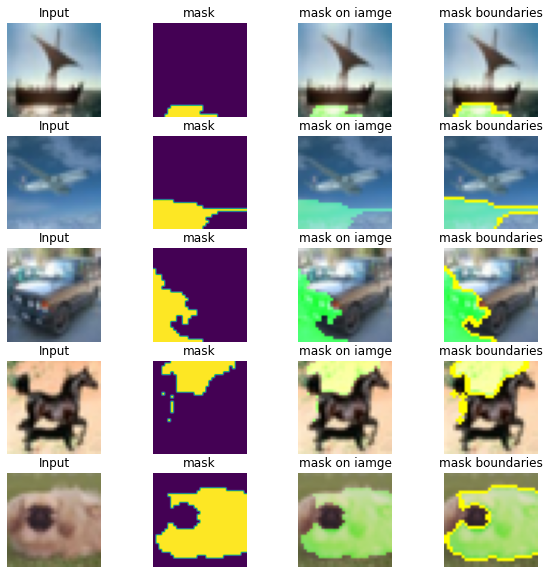

In [15]:

fig, ax = plt.subplots(5,4, figsize=(10, 10))
for i in range(5):
    img = imgs[i]
    label = labels[i].item()
    mask, img_boundry2, mask_on_img = limeExplanation(img, label)
    plotrow(ax, i, img, mask, img_boundry2, mask_on_img)

plt.show()

In [16]:
dataset_test_lime = generate_masked_dataset(dataset_test, mask_generator = lambda x, y : limeExplanation(x,y)[0], max_iters = 100)
test_loader_lime = torch.utils.data.DataLoader(dataset_test_lime, test_batch_size, shuffle = True)

In [17]:
acc_lime = test(model, epoch, test_loader_lime, criterion, verbose = False)
print (f"lime accuracy on cifar dataset is {acc_lime} ")


lime accuracy on cifar dataset is 32.35294117647059 


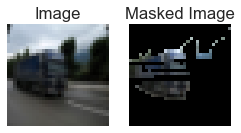

In [108]:
plot_in_row(dataset_test_lime, 0)

# Shapley (DeepExplainer)

In [19]:
model_shapley = deepcopy (model)

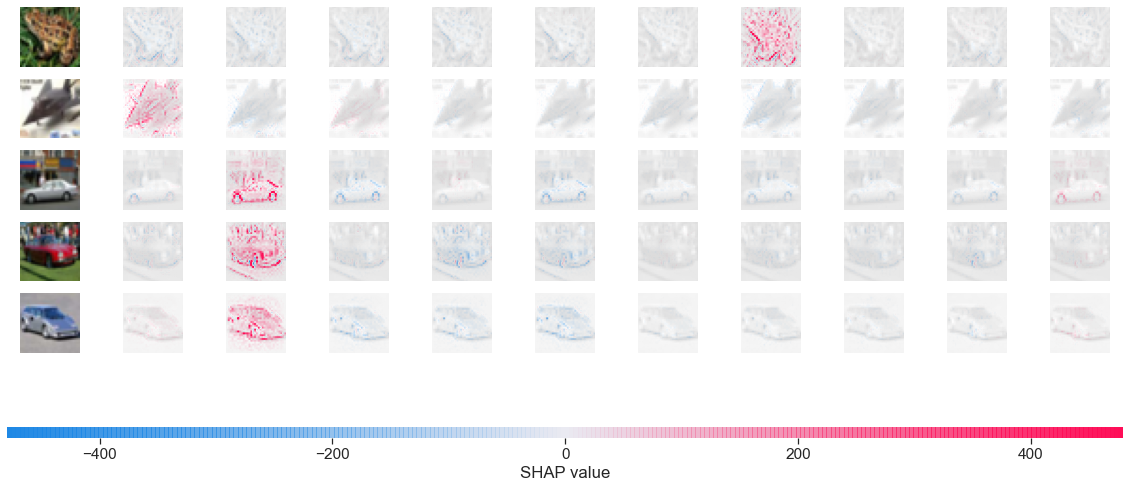

In [47]:
import shap
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch
images = images.to(device)
model_shapley.eval()

test_batch_size = len(images)

background = images[:test_batch_size-5]
test_images = images[test_batch_size-5:]

e = shap.DeepExplainer(model_shapley, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)


# plot the feature attributions
shap.image_plot(shap_numpy, test_numpy)

In [21]:
def shapExplanation(x,y):
    shap_values = e.shap_values(x[None].to(device))
    torch.cuda.empty_cache()
    return torch.tensor(shap_values[y][0]).sum(0)

In [22]:
dataset_test_shap = generate_masked_dataset(dataset_test, shapExplanation, max_iters = 100)
test_loader_shap = torch.utils.data.DataLoader(dataset_test_shap, test_batch_size, shuffle = True)

In [23]:
acc_shap = test(model, epoch, test_loader_shap, criterion, verbose = False)
print (f"shap accuracy on cifar dataset is {acc_shap} ")


shap accuracy on cifar dataset is 12.745098039215685 


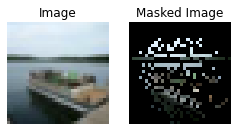

In [24]:
plot_in_row(dataset_test_shap, 37)

# lrp

In [25]:
import lrp
from visualization import project, clip_quantile, heatmap_grid, grid
from lrp.patterns import fit_patternnet, fit_patternnet_positive # PatternNet patterns


In [26]:
model_lrp = lrp.convert_vgg(deepcopy (model)).to(device)

In [27]:
patterns = fit_patternnet_positive(model_lrp, train_loader, device=device)

100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [01:33<00:00,  4.18it/s]


In [28]:

batch = next(iter(test_loader))
x, y = batch
x = x[:6]
y = y[:6]

x = x.to(device)
x = x.requires_grad_(True)

batch_to_append = batch[0][:31].clone()
batch_to_append = batch_to_append
batch_to_append = batch_to_append.requires_grad_(True)

In [29]:
def LRPMask(x, model_lrp, rule, patterns):
    x = x.to(device)
    x = x.detach()
    x.requires_grad_(True)
    
    # Forward pass
    y_hat_lrp = model_lrp.forward(x, explain=True, rule=rule, pattern=patterns)

    # Choose argmax
    y_hat_lrp = y_hat_lrp[torch.arange(x.shape[0]), y_hat_lrp.max(1)[1]]
    y_hat_lrp = y_hat_lrp.sum()

    # Backward pass (compute explanation)
    y_hat_lrp.backward()
    attr = x.grad    
    return attr

def compute_and_plot_explanation(x, model_lrp, rule, ax_, patterns=None, plt_fn=heatmap_grid): 
    
    attr = LRPMask(x, model_lrp, rule, patterns)

    # Plot
    attr = plt_fn(attr)

    ax_.imshow(attr)
    ax_.set_title(rule)
    ax_.axis('off')
# PatternNet is typically handled a bit different, when visualized.
def signal_fn(X):
    if X.shape[1] in [1, 3]: X = X.permute(0, 2, 3, 1).detach().cpu().numpy()
    X = clip_quantile(X)
    X = project(X)
    X = grid(X)
    return X

def lrpExplanation(x, y):
    return LRPMask(torch.cat ([x[None],batch_to_append]), model_lrp, rule = 'alpha1beta0', patterns = None)[0].cpu().sum(0)

Plotting


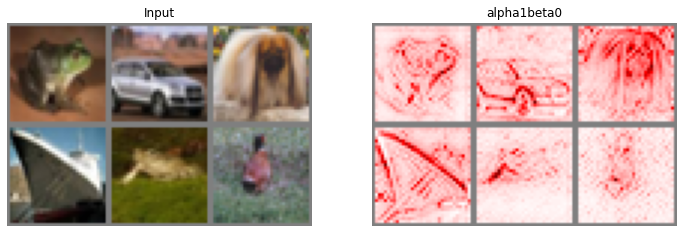

In [30]:
explanations = [
        # rule                  Pattern     plt_fn          Fig. pos
        ('alpha1beta0',         None,       heatmap_grid,   1), 
    ]

fig, ax = plt.subplots(1, 2, figsize=(12, 8))
print("Plotting")

# Plot inputs
input_to_plot = x.permute(0, 2, 3, 1).contiguous().detach().cpu().numpy()
input_to_plot = grid(input_to_plot, 3, 1.)
ax[0].imshow(input_to_plot)
ax[0].set_title("Input")
ax[0].axis('off')

# Plot explanations
for i, (rule, pattern, fn, p ) in enumerate(explanations): 
    compute_and_plot_explanation(x, model_lrp, rule, ax[p], patterns=pattern, plt_fn=fn)



In [31]:
dataset_test_lrp = generate_masked_dataset(dataset_test, lrpExplanation, max_iters = 100)

In [32]:
test_loader_lrp = torch.utils.data.DataLoader(dataset_test_lrp, test_batch_size, shuffle = True)
acc_lrp = test(model, epoch, test_loader_lrp, criterion, verbose = False)
print (f"lime accuracy on cifar dataset is {acc_lrp} ")


lime accuracy on cifar dataset is 17.647058823529413 


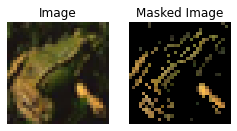

In [33]:
plot_in_row(dataset_test_lrp, 5)

# Comparing Methods

In [34]:
import seaborn as sns
sns.set_style('dark')
# sns.set_style('white')
sns.set_context('notebook', font_scale=1.4, rc={'lines.linewidth': 1.2})
# sns.set(rc={'figure.facecolor':'cornflowerblue'})
# sns.set(rc={'figure.facecolor':'cornflowerblue'})
sns.set_palette('bright')

sns.despine()

<Figure size 432x288 with 0 Axes>

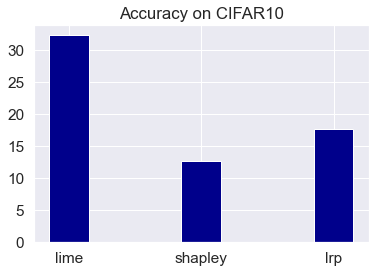

In [35]:
names = ['lime', 'shapley', 'lrp']
accs = [acc_lime, acc_shap, acc_lrp]

# Horizontal Bar Plot
plt.figure(figsize = (6,4))
plt.bar(names, accs, width = 0.3, color = 'darkblue')
plt.title('Accuracy on CIFAR10')
plt.grid()
# Show Plot
plt.show()


# GradCam

In [36]:
class VGG(nn.Module):
    def __init__(self, model, layer):
        super(VGG, self).__init__()
        
        # disect the network to access its last convolutional layer
        self.features_conv = model.features[:layer]
        
        # get the max pool of the features stem
        self.max_pool = model.features[layer:]
        
        # get the classifier of the vgg19
        self.classifier = torch.nn.Sequential (model.avgpool, nn.Flatten() , model.classifier)
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
#         print (x.shape)
#         x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [37]:
model_gradcam = VGG(deepcopy(model), layer = 24)
model_gradcam = model_gradcam.to(device)
model_gradcam = model_gradcam.eval()


In [99]:
images, labels = next(iter(test_loader))
image, label = images[0], labels[0]
image = image.to(device)

In [100]:
import cv2
def gradcamExplanation(image, label):
    images = image[None]
    pred = model_gradcam(images)
    pred[:, label.item()].backward()
    gradients = model_gradcam.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model_gradcam.get_activations(images).detach()

    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze().cpu().detach()

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
#     plt.matshow(heatmap.squeeze())

    heatmap = cv2.resize(heatmap.numpy(), (32,32))
    heatmap = np.uint8(255 * (1 - heatmap))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = torch.tensor (heatmap).permute([2,0,1])
    # heatmap[0],heatmap[2] = heatmap[2],heatmap[0]
    superimposed_img = heatmap.to(torch.float32) * 0.5 / 255 + images.cpu()
    return superimposed_img

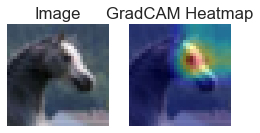

In [101]:
superimposed_img = gradcamExplanation (image, label)
plot_row(images.cpu()[0], superimposed_img[0])

# Filters analysis

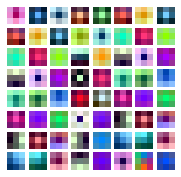

In [41]:
fig, ax = plt.subplots(8,8, figsize=(3, 3))
for i in range(8):
    for j in range(8):
        ax[i,j].imshow (normalize_and_permute(model.features[0].state_dict()['weight'][i * 5 + j].cpu()))
        ax[i,j].axis('off')

(-0.5, 31.5, 31.5, -0.5)

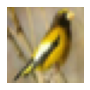

In [53]:
imgs,labels = next (iter (test_loader))
f = model.features[0](imgs.to(device)).to('cpu')
plt.figure(figsize=(1.4,1.4))
plt.imshow (normalize_and_permute (imgs[0]).cpu())
plt.axis('off')

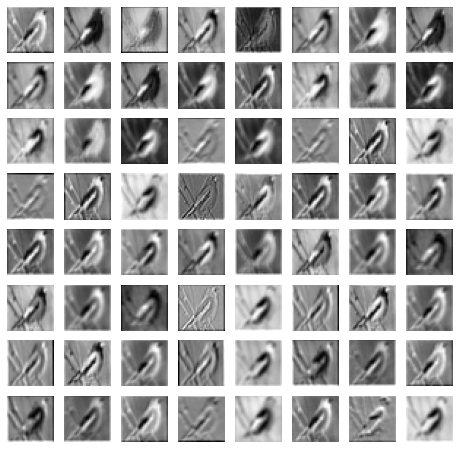

In [54]:
fig, ax = plt.subplots(8,8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i,j].imshow (f.detach().cpu()[0][i * 5 + j], cmap = 'gray')
        ax[i,j].axis('off')

In [55]:

batch = next(iter(test_loader))
x, y = batch
x = x[:3]
y = y[:3]

x = x.to(device)
x = x.requires_grad_(True)


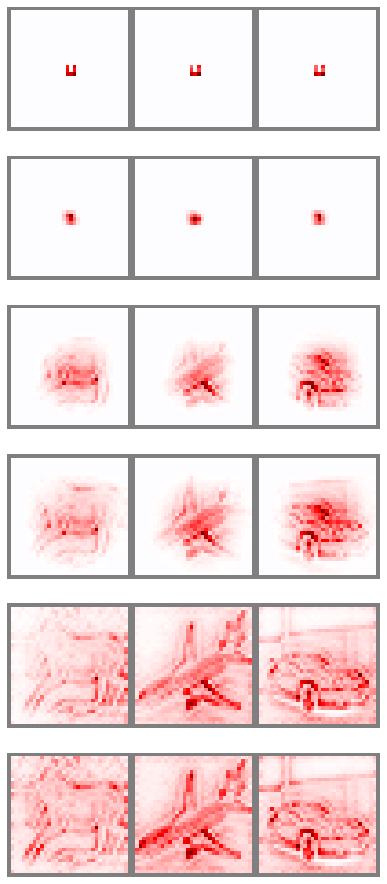

In [62]:
fig, ax = plt.subplots(6,1, figsize=(16, 16))

for i, layer_to_look in enumerate ([1, 4, 15, 18, 28, 41]):
    new_model = lrp.Sequential(*(model_lrp[:layer_to_look]))
#     xp = new_model.forward(x, explain=True, rule=rule, pattern=patterns)

    x = x.to(device)
    x = x.detach()
    x.requires_grad_(True)

    # Forward pass
    y_hat_lrp = new_model.forward(x, explain=True, rule='alpha1beta0', pattern=None)

    # Choose argmax
    _,_,w,h = y_hat_lrp.shape
    y_hat_lrp = y_hat_lrp[:,0,w//2,h//2]
    y_hat_lrp = y_hat_lrp.sum()

    # Backward pass (compute explanation)
    y_hat_lrp.backward()
    attr = x.grad    
    plt_fn = heatmap_grid
    attr = plt_fn(attr)

    ax[i].imshow(attr)
    ax[i].axis('off')
plt.show()

# Retraining

In [109]:

dataset_train_no_transform = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True, transform=transform_test)


Files already downloaded and verified


In [110]:
dataset_train_lrp = generate_masked_dataset(dataset_train_no_transform, lrpExplanation, max_iters=1000)
train_loader_lrp = torch.utils.data.DataLoader(dataset_train_lrp, test_batch_size, shuffle = True)
test(model, epoch, train_loader_lrp, criterion, verbose = True)

epoch:0, 0/11 Loss: 4.737 | Acc: 27.000% (27/100)
epoch:0, 1/11 Loss: 5.046 | Acc: 24.500% (49/200)
epoch:0, 2/11 Loss: 5.329 | Acc: 21.333% (64/300)
epoch:0, 3/11 Loss: 5.395 | Acc: 21.750% (87/400)
epoch:0, 4/11 Loss: 5.310 | Acc: 22.000% (110/500)
epoch:0, 5/11 Loss: 5.307 | Acc: 22.000% (132/600)
epoch:0, 6/11 Loss: 5.301 | Acc: 22.143% (155/700)
epoch:0, 7/11 Loss: 5.297 | Acc: 23.250% (186/800)
epoch:0, 8/11 Loss: 5.301 | Acc: 23.000% (207/900)
epoch:0, 9/11 Loss: 5.344 | Acc: 23.300% (233/1000)
epoch:0, 10/11 Loss: 5.026 | Acc: 23.353% (234/1002)



23.353293413173652

In [111]:
class MixedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset1, dataset2, p = 0.02):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.p = p
        
    def update_indices(self):
        self.indices = np.random.choice(len(self.dataset1), int (len(self.dataset1) * self.p))
                
    def __len__(self):
        return len(self.indices) + len (self.dataset2)

    def __getitem__(self, idx):
        if idx < len (self.dataset2):
#             print ("dataset2")
            return self.dataset2.__getitem__(idx)
        else:
#             print ("dataset1")
            new_idx = idx - len(self.dataset2)
            img, label = self.dataset1.__getitem__(new_idx)
            return img, torch.tensor(label)
        

In [112]:
mixedDataset = MixedDataset(dataset_train , dataset_train_lrp)
mixedDataset.update_indices()
mixed_loader = torch.utils.data.DataLoader (mixedDataset, batch_size, shuffle = True)

In [113]:
from copy import deepcopy
with torch.no_grad():
    model_retrained = deepcopy(model)

optimizer_retrain = optim.SGD(model_retrained.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-4)

In [114]:
for epoch in tqdm (range(10)):
    mixedDataset.update_indices()
    
    train(model_retrained, epoch, mixed_loader, optimizer_retrain, criterion)
    
    model_lrp = lrp.convert_vgg(deepcopy (model_retrained)).to(device)
    
    acc1 = test(model_retrained, epoch, test_loader, criterion, verbose = False)
    acc2 = test(model_retrained, epoch, train_loader_lrp, criterion, verbose = False)
    acc3 = test(model_retrained, epoch, test_loader_lrp, criterion, verbose = False)
    print (f"acc test: {acc1} | ", f"acc train masked: {acc2} | ",  f"acc test masked: {acc3},")


Epoch: 0


epoch:0, 0/16 Loss: 1.619 | Acc: 72.656% (93/128)
epoch:0, 1/16 Loss: 1.361 | Acc: 78.906% (202/256)
epoch:0, 2/16 Loss: 1.544 | Acc: 77.083% (296/384)
epoch:0, 3/16 Loss: 1.553 | Acc: 75.977% (389/512)
epoch:0, 4/16 Loss: 1.465 | Acc: 77.500% (496/640)
epoch:0, 5/16 Loss: 1.493 | Acc: 76.562% (588/768)
epoch:0, 6/16 Loss: 1.471 | Acc: 76.562% (686/896)
epoch:0, 7/16 Loss: 1.478 | Acc: 75.977% (778/1024)
epoch:0, 8/16 Loss: 1.462 | Acc: 76.215% (878/1152)
epoch:0, 9/16 Loss: 1.420 | Acc: 76.719% (982/1280)
epoch:0, 10/16 Loss: 1.378 | Acc: 77.202% (1087/1408)
epoch:0, 11/16 Loss: 1.371 | Acc: 77.214% (1186/1536)
epoch:0, 12/16 Loss: 1.358 | Acc: 77.284% (1286/1664)
epoch:0, 13/16 Loss: 1.335 | Acc: 77.679% (1392/1792)
epoch:0, 14/16 Loss: 1.327 | Acc: 77.917% (1496/1920)
epoch:0, 15/16 Loss: 1.308 | Acc: 78.072% (1563/2002)




acc test: 90.59 |  acc train masked: 66.66666666666667 |  acc test masked: 45.09803921568628,

Epoch: 1


epoch:1, 0/16 Loss: 0.951 | Acc: 84.375% (108/128)
epoch:1, 1/16 Loss: 0.877 | Acc: 83.594% (214/256)
epoch:1, 2/16 Loss: 0.963 | Acc: 82.552% (317/384)
epoch:1, 3/16 Loss: 0.861 | Acc: 84.180% (431/512)
epoch:1, 4/16 Loss: 0.897 | Acc: 83.594% (535/640)
epoch:1, 5/16 Loss: 0.874 | Acc: 83.984% (645/768)
epoch:1, 6/16 Loss: 0.871 | Acc: 83.817% (751/896)
epoch:1, 7/16 Loss: 0.847 | Acc: 83.691% (857/1024)
epoch:1, 8/16 Loss: 0.840 | Acc: 83.681% (964/1152)
epoch:1, 9/16 Loss: 0.853 | Acc: 83.750% (1072/1280)
epoch:1, 10/16 Loss: 0.836 | Acc: 84.091% (1184/1408)
epoch:1, 11/16 Loss: 0.820 | Acc: 84.505% (1298/1536)
epoch:1, 12/16 Loss: 0.809 | Acc: 84.675% (1409/1664)
epoch:1, 13/16 Loss: 0.793 | Acc: 84.710% (1518/1792)
epoch:1, 14/16 Loss: 0.792 | Acc: 84.688% (1626/1920)
epoch:1, 15/16 Loss: 0.779 | Acc: 84.865% (1699/2002)




acc test: 90.61 |  acc train masked: 78.1437125748503 |  acc test masked: 45.09803921568628,

Epoch: 2


epoch:2, 0/16 Loss: 0.314 | Acc: 90.625% (116/128)
epoch:2, 1/16 Loss: 0.471 | Acc: 89.453% (229/256)
epoch:2, 2/16 Loss: 0.485 | Acc: 89.323% (343/384)
epoch:2, 3/16 Loss: 0.543 | Acc: 88.281% (452/512)
epoch:2, 4/16 Loss: 0.575 | Acc: 88.281% (565/640)
epoch:2, 5/16 Loss: 0.535 | Acc: 89.062% (684/768)
epoch:2, 6/16 Loss: 0.527 | Acc: 89.397% (801/896)
epoch:2, 7/16 Loss: 0.486 | Acc: 90.039% (922/1024)
epoch:2, 8/16 Loss: 0.490 | Acc: 89.757% (1034/1152)
epoch:2, 9/16 Loss: 0.471 | Acc: 89.922% (1151/1280)
epoch:2, 10/16 Loss: 0.475 | Acc: 89.844% (1265/1408)
epoch:2, 11/16 Loss: 0.476 | Acc: 89.583% (1376/1536)
epoch:2, 12/16 Loss: 0.473 | Acc: 89.724% (1493/1664)
epoch:2, 13/16 Loss: 0.482 | Acc: 89.453% (1603/1792)
epoch:2, 14/16 Loss: 0.498 | Acc: 89.167% (1712/1920)
epoch:2, 15/16 Loss: 0.497 | Acc: 89.111% (1784/2002)




acc test: 90.62 |  acc train masked: 85.82834331337325 |  acc test masked: 46.07843137254902,

Epoch: 3


epoch:3, 0/16 Loss: 0.286 | Acc: 93.750% (120/128)
epoch:3, 1/16 Loss: 0.260 | Acc: 93.750% (240/256)
epoch:3, 2/16 Loss: 0.242 | Acc: 94.531% (363/384)
epoch:3, 3/16 Loss: 0.241 | Acc: 94.531% (484/512)
epoch:3, 4/16 Loss: 0.242 | Acc: 94.375% (604/640)
epoch:3, 5/16 Loss: 0.249 | Acc: 94.010% (722/768)
epoch:3, 6/16 Loss: 0.281 | Acc: 93.080% (834/896)
epoch:3, 7/16 Loss: 0.288 | Acc: 92.871% (951/1024)
epoch:3, 8/16 Loss: 0.316 | Acc: 92.014% (1060/1152)
epoch:3, 9/16 Loss: 0.320 | Acc: 92.188% (1180/1280)
epoch:3, 10/16 Loss: 0.318 | Acc: 92.330% (1300/1408)
epoch:3, 11/16 Loss: 0.319 | Acc: 92.122% (1415/1536)
epoch:3, 12/16 Loss: 0.326 | Acc: 91.947% (1530/1664)
epoch:3, 13/16 Loss: 0.331 | Acc: 92.020% (1649/1792)
epoch:3, 14/16 Loss: 0.337 | Acc: 91.823% (1763/1920)
epoch:3, 15/16 Loss: 0.323 | Acc: 92.008% (1842/2002)




acc test: 90.7 |  acc train masked: 90.31936127744511 |  acc test masked: 47.05882352941177,

Epoch: 4


epoch:4, 0/16 Loss: 0.279 | Acc: 92.969% (119/128)
epoch:4, 1/16 Loss: 0.241 | Acc: 94.141% (241/256)
epoch:4, 2/16 Loss: 0.205 | Acc: 94.792% (364/384)
epoch:4, 3/16 Loss: 0.181 | Acc: 95.703% (490/512)
epoch:4, 4/16 Loss: 0.219 | Acc: 94.844% (607/640)
epoch:4, 5/16 Loss: 0.221 | Acc: 95.052% (730/768)
epoch:4, 6/16 Loss: 0.227 | Acc: 94.754% (849/896)
epoch:4, 7/16 Loss: 0.236 | Acc: 94.531% (968/1024)
epoch:4, 8/16 Loss: 0.238 | Acc: 94.618% (1090/1152)
epoch:4, 9/16 Loss: 0.237 | Acc: 94.453% (1209/1280)
epoch:4, 10/16 Loss: 0.240 | Acc: 94.389% (1329/1408)
epoch:4, 11/16 Loss: 0.243 | Acc: 94.531% (1452/1536)
epoch:4, 12/16 Loss: 0.244 | Acc: 94.351% (1570/1664)
epoch:4, 13/16 Loss: 0.232 | Acc: 94.587% (1695/1792)
epoch:4, 14/16 Loss: 0.241 | Acc: 94.531% (1815/1920)
epoch:4, 15/16 Loss: 0.239 | Acc: 94.605% (1894/2002)




acc test: 90.86 |  acc train masked: 93.31337325349301 |  acc test masked: 48.03921568627451,

Epoch: 5


epoch:5, 0/16 Loss: 0.163 | Acc: 95.312% (122/128)
epoch:5, 1/16 Loss: 0.153 | Acc: 95.312% (244/256)
epoch:5, 2/16 Loss: 0.208 | Acc: 94.531% (363/384)
epoch:5, 3/16 Loss: 0.209 | Acc: 94.727% (485/512)
epoch:5, 4/16 Loss: 0.179 | Acc: 95.625% (612/640)
epoch:5, 5/16 Loss: 0.192 | Acc: 95.312% (732/768)
epoch:5, 6/16 Loss: 0.194 | Acc: 95.424% (855/896)
epoch:5, 7/16 Loss: 0.178 | Acc: 95.703% (980/1024)
epoch:5, 8/16 Loss: 0.179 | Acc: 95.660% (1102/1152)
epoch:5, 9/16 Loss: 0.164 | Acc: 95.938% (1228/1280)
epoch:5, 10/16 Loss: 0.166 | Acc: 95.810% (1349/1408)
epoch:5, 11/16 Loss: 0.170 | Acc: 95.833% (1472/1536)
epoch:5, 12/16 Loss: 0.178 | Acc: 95.733% (1593/1664)
epoch:5, 13/16 Loss: 0.180 | Acc: 95.703% (1715/1792)
epoch:5, 14/16 Loss: 0.176 | Acc: 95.885% (1841/1920)
epoch:5, 15/16 Loss: 0.173 | Acc: 96.004% (1922/2002)




acc test: 91.01 |  acc train masked: 95.50898203592814 |  acc test masked: 48.03921568627451,

Epoch: 6


epoch:6, 0/16 Loss: 0.195 | Acc: 96.875% (124/128)
epoch:6, 1/16 Loss: 0.142 | Acc: 96.484% (247/256)
epoch:6, 2/16 Loss: 0.126 | Acc: 97.396% (374/384)
epoch:6, 3/16 Loss: 0.128 | Acc: 97.656% (500/512)
epoch:6, 4/16 Loss: 0.150 | Acc: 97.188% (622/640)
epoch:6, 5/16 Loss: 0.138 | Acc: 97.396% (748/768)
epoch:6, 6/16 Loss: 0.124 | Acc: 97.656% (875/896)
epoch:6, 7/16 Loss: 0.119 | Acc: 97.754% (1001/1024)
epoch:6, 8/16 Loss: 0.117 | Acc: 97.743% (1126/1152)
epoch:6, 9/16 Loss: 0.120 | Acc: 97.500% (1248/1280)
epoch:6, 10/16 Loss: 0.122 | Acc: 97.514% (1373/1408)
epoch:6, 11/16 Loss: 0.123 | Acc: 97.461% (1497/1536)
epoch:6, 12/16 Loss: 0.124 | Acc: 97.296% (1619/1664)
epoch:6, 13/16 Loss: 0.131 | Acc: 97.210% (1742/1792)
epoch:6, 14/16 Loss: 0.129 | Acc: 97.188% (1866/1920)
epoch:6, 15/16 Loss: 0.141 | Acc: 96.903% (1940/2002)




acc test: 91.0 |  acc train masked: 96.30738522954091 |  acc test masked: 49.01960784313726,

Epoch: 7


epoch:7, 0/16 Loss: 0.146 | Acc: 96.875% (124/128)
epoch:7, 1/16 Loss: 0.134 | Acc: 97.266% (249/256)
epoch:7, 2/16 Loss: 0.108 | Acc: 97.135% (373/384)
epoch:7, 3/16 Loss: 0.108 | Acc: 97.266% (498/512)
epoch:7, 4/16 Loss: 0.092 | Acc: 97.812% (626/640)
epoch:7, 5/16 Loss: 0.098 | Acc: 97.917% (752/768)
epoch:7, 6/16 Loss: 0.102 | Acc: 97.656% (875/896)
epoch:7, 7/16 Loss: 0.094 | Acc: 97.754% (1001/1024)
epoch:7, 8/16 Loss: 0.102 | Acc: 97.656% (1125/1152)
epoch:7, 9/16 Loss: 0.099 | Acc: 97.734% (1251/1280)
epoch:7, 10/16 Loss: 0.100 | Acc: 97.727% (1376/1408)
epoch:7, 11/16 Loss: 0.103 | Acc: 97.721% (1501/1536)
epoch:7, 12/16 Loss: 0.106 | Acc: 97.656% (1625/1664)
epoch:7, 13/16 Loss: 0.105 | Acc: 97.712% (1751/1792)
epoch:7, 14/16 Loss: 0.108 | Acc: 97.656% (1875/1920)
epoch:7, 15/16 Loss: 0.106 | Acc: 97.702% (1956/2002)




acc test: 90.98 |  acc train masked: 96.9061876247505 |  acc test masked: 49.01960784313726,

Epoch: 8


epoch:8, 0/16 Loss: 0.069 | Acc: 99.219% (127/128)
epoch:8, 1/16 Loss: 0.047 | Acc: 99.609% (255/256)
epoch:8, 2/16 Loss: 0.072 | Acc: 98.438% (378/384)
epoch:8, 3/16 Loss: 0.064 | Acc: 98.438% (504/512)
epoch:8, 4/16 Loss: 0.069 | Acc: 98.281% (629/640)
epoch:8, 5/16 Loss: 0.084 | Acc: 98.047% (753/768)
epoch:8, 6/16 Loss: 0.087 | Acc: 97.879% (877/896)
epoch:8, 7/16 Loss: 0.089 | Acc: 97.852% (1002/1024)
epoch:8, 8/16 Loss: 0.088 | Acc: 98.003% (1129/1152)
epoch:8, 9/16 Loss: 0.085 | Acc: 98.125% (1256/1280)
epoch:8, 10/16 Loss: 0.082 | Acc: 98.224% (1383/1408)
epoch:8, 11/16 Loss: 0.081 | Acc: 98.307% (1510/1536)
epoch:8, 12/16 Loss: 0.089 | Acc: 98.077% (1632/1664)
epoch:8, 13/16 Loss: 0.084 | Acc: 98.214% (1760/1792)
epoch:8, 14/16 Loss: 0.084 | Acc: 98.229% (1886/1920)
epoch:8, 15/16 Loss: 0.087 | Acc: 98.152% (1965/2002)




acc test: 91.14 |  acc train masked: 97.2055888223553 |  acc test masked: 49.01960784313726,

Epoch: 9


epoch:9, 0/16 Loss: 0.029 | Acc: 100.000% (128/128)
epoch:9, 1/16 Loss: 0.043 | Acc: 99.609% (255/256)
epoch:9, 2/16 Loss: 0.034 | Acc: 99.740% (383/384)
epoch:9, 3/16 Loss: 0.069 | Acc: 98.438% (504/512)
epoch:9, 4/16 Loss: 0.061 | Acc: 98.750% (632/640)
epoch:9, 5/16 Loss: 0.061 | Acc: 98.698% (758/768)
epoch:9, 6/16 Loss: 0.063 | Acc: 98.549% (883/896)
epoch:9, 7/16 Loss: 0.069 | Acc: 98.438% (1008/1024)
epoch:9, 8/16 Loss: 0.069 | Acc: 98.438% (1134/1152)
epoch:9, 9/16 Loss: 0.076 | Acc: 98.281% (1258/1280)
epoch:9, 10/16 Loss: 0.082 | Acc: 97.798% (1377/1408)
epoch:9, 11/16 Loss: 0.079 | Acc: 97.917% (1504/1536)
epoch:9, 12/16 Loss: 0.076 | Acc: 98.017% (1631/1664)
epoch:9, 13/16 Loss: 0.073 | Acc: 98.103% (1758/1792)
epoch:9, 14/16 Loss: 0.075 | Acc: 97.969% (1881/1920)
epoch:9, 15/16 Loss: 0.078 | Acc: 97.952% (1961/2002)




acc test: 91.02 |  acc train masked: 98.10379241516966 |  acc test masked: 49.01960784313726,



In [117]:
acc_lime = test(model_retrained, epoch, test_loader_lime, criterion, verbose = False)
print (f"lime accuracy on cifar dataset is {acc_lime} ")


lime accuracy on cifar dataset is 29.41176470588235 


In [118]:
acc_shap = test(model_retrained, epoch, test_loader_shap, criterion, verbose = False)
print (f"shap accuracy on cifar dataset is {acc_shap} ")


shap accuracy on cifar dataset is 50.0 


In [119]:
acc_lrp = test(model_retrained, epoch, test_loader_lrp, criterion, verbose = False)
print (f"shap accuracy on cifar dataset is {acc_shap} ")


shap accuracy on cifar dataset is 50.0 


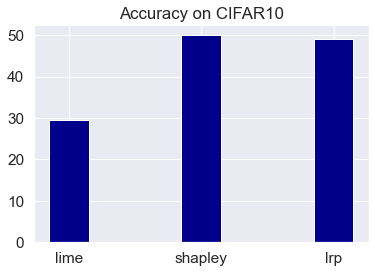

In [120]:
names = ['lime', 'shapley', 'lrp']
accs = [acc_lime, acc_shap, acc_lrp]

# Horizontal Bar Plot
plt.figure(figsize = (6,4))
plt.bar(names, accs, width = 0.3, color = 'darkblue')
plt.title('Accuracy on CIFAR10')
plt.grid()
# Show Plot
plt.show()